In [55]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import numpy as np
from datetime import timedelta

In [56]:
# Read dataset
transaction_df = pd.read_excel('Sample_Data_Offer_Customer_Transaction\Offer_Transaction_Log.xlsx')
#transaction_df.to_csv("transaction_df.csv")
transaction_df.drop(['OfferTargetAge'], 1, inplace=True)

cust_df = pd.read_excel("Sample_Data_Offer_Customer_Transaction\Customer_Master.xlsx")
#cust_df.to_csv("cust_df.csv")
cust_df.drop(['CustomerTitle','CustomerMaritalStatus','CustomerAgeSegment','CustomerAge','CustomerTier'], 1,
             inplace=True)

offer_df = pd.read_excel("Sample_Data_Offer_Customer_Transaction\Offer_Master.xlsx")
#offer_df.to_csv("offer_df.csv")
offer_df.drop(['TargetedMaritalStatus','TargetedTier','TargetedGender','TargetedAge'],1,inplace=True)

#joining the data
joinedData_df = cust_df.merge(transaction_df, on = 'CustomerID',how ='inner')
#joinedData_df.to_csv("Join.csv" , index=False)
joinedData_df.head()

,CustomerID,CustomerGender,CustomerCountry,OfferId,OfferTransactionDate,TransactionAmount,Points,Accrual,Redemption,CustomerTier,OfferTier,CustomerAge,OSD,OED
0,60129,M,NaN,O0100,2019-12-29,4800,300,0,1,B,Gold,18,2019-10-01,2019-12-31
1,63563,F,NaN,O0100,2019-12-17,3900,300,1,0,B,Gold,18,2019-10-01,2019-12-31
2,63563,F,NaN,O0101,2019-11-16,3300,300,1,0,B,Gold,18,2019-10-01,2019-12-31
3,60421,F,NaN,O0100,2019-12-24,5400,300,0,1,B,Gold,17,2019-10-01,2019-12-31
4,57914,M,IN,O0095,2019-07-14,1000,50,0,1,B,Bronze,3,2019-07-01,2019-10-31


In [57]:
#map
def Rename_OfferTier(df):
    for col in ['CustomerTier']:
        df[col] = df[col].map({'B':'Bronze', 'S':'Saphire','P':'Platinum','G':'Gold'})
    return df
joinedData_df = Rename_OfferTier(joinedData_df)
#join again
offerTransaction = offer_df.merge(joinedData_df, on='OfferId',how='inner')

In [58]:
# Convert InvoiceDate from object to datetime format
offerTransaction['InvoiceDate'] = pd.to_datetime(offerTransaction['OfferTransactionDate'])

# Drop NA values from online
offerTransaction.drop(['CustomerCountry','OfferType','ExclusionCategory','PointType','ProgramPointType'
                      ,'ProductCategory','Season','Month','WeekDay','Holiday','WeekEnd','BirthDay',
                      'Duration','Unnamed: 27','PartnerCategory','PartnerType','Targetted Type','Points_y'
                      ],1,inplace=True)
del offerTransaction['WeddingAnniversary ']
offerTransaction['ProgramCode'].fillna(method='ffill',inplace=True)
offerTransaction['PartnerCode'].fillna(method='ffill',inplace=True)
offerTransaction['PartnerName'].fillna(method='ffill',inplace=True)
offerTransaction['Targetted Nationality'].fillna(method='ffill',inplace=True)
offerTransaction['Targetted Preference Group'].fillna(method='ffill',inplace=True)
offerTransaction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5572 entries, 0 to 5571
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   OfferId                     5572 non-null   object        
 1   OfferName                   5572 non-null   object        
 2   OfferCategory               5572 non-null   object        
 3   OfferContent                5572 non-null   object        
 4   OfferChannel                5572 non-null   object        
 5   Points_x                    5572 non-null   float64       
 6   BenefitType                 5572 non-null   object        
 7   ProgramCode                 5572 non-null   object        
 8   ProgramName                 5572 non-null   object        
 9   ProgramTier                 5572 non-null   object        
 10  ProductCode                 5572 non-null   object        
 11  ProductName                 5572 non-null   object      

In [59]:
# --Group data by customerID--
# Create snapshot date
snapshot_date = offerTransaction['InvoiceDate'].max() + timedelta(days=1)
print(snapshot_date)

# Grouping by CustomerID
data_process = offerTransaction.groupby(['CustomerID'],as_index=False).agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'OfferId': 'count',
        'TransactionAmount': 'sum'})
print(data_process.columns.tolist())
# Rename the columns
data_process.rename(columns={'InvoiceDate': 'Recency',
                         'OfferId': 'Frequency',
                         'TransactionAmount': 'MonetaryValue'}, inplace=True)
data_process.head()

2020-02-01 00:00:00
['CustomerID', 'InvoiceDate', 'OfferId', 'TransactionAmount']


,CustomerID,Recency,Frequency,MonetaryValue
0,311,11,7,43250
1,3404,39,6,22300
2,3412,148,7,20350
3,3623,164,7,54450
4,5104,30,7,20750


In [60]:
# Preprocessing the data to make it visualizable
  
# Scaling the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_process)
  
# Normalizing the Data
X_normalized = normalize(X_scaled)
  
# Converting the numpy array into a pandas DataFrame
X_normalized = pd.DataFrame(X_normalized)
  
# Reducing the dimensions of the data
pca = PCA(n_components = 2)
X_principal = pca.fit_transform(X_normalized)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2']
  
X_principal.head()

,P1,P2
0,-0.106611,0.333946
1,0.117470,0.336460
2,0.254106,0.698240
3,0.073785,0.859370
4,0.075627,0.300657


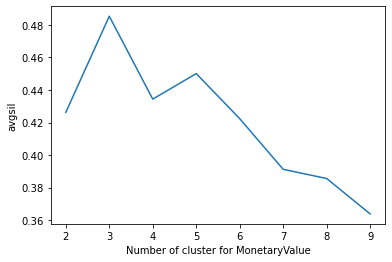

In [62]:
# data-structure to store Sum-Of-Square-Errors
sse = {}
# Looping over multiple values of k from 1 to 30
for k in range(2, 10):
    spectral_model_rbf = SpectralClustering(n_clusters = k, affinity ='rbf',assign_labels='kmeans')
    labels_rbf = spectral_model_rbf.fit(X_principal)
    sse[k] = silhouette_score(X_principal,labels_rbf.labels_)
# Plotting the curve with 'k'-value vs SSE
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster for MonetaryValue")
plt.ylabel("avgsil")
# Save the Plot in current directory
plt.show()


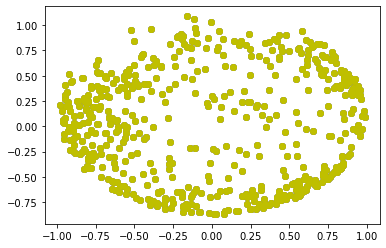

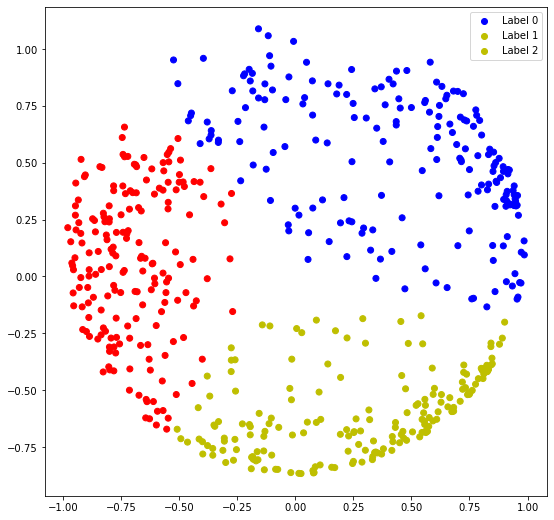

In [68]:
# Building the clustering model
spectral_model_rbf = SpectralClustering(n_clusters = 3, affinity ='nearest_neighbors')
  
# Training the model and Storing the predicted cluster labels
labels_rbf = spectral_model_rbf.fit_predict(X_principal)

# Building the label to colour mapping
colours = {}
colours[0] = 'b'
colours[1] = 'y'
colours[2] = 'r'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels_rbf]
  
# Plotting the clustered scatter plot
  
b = plt.scatter(X_principal['P1'], X_principal['P2'], color ='b');
y = plt.scatter(X_principal['P1'], X_principal['P2'], color ='y');
r = plt.scatter(X_principal['P1'], X_principal['P2'], color ='y');
  
plt.figure(figsize =(9, 9))
plt.scatter(X_principal['P1'], X_principal['P2'], c = cvec)
plt.legend((b, y, r), ('Label 0', 'Label 1', 'Label 2'))
plt.show()